## Mixture Models

In [8]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV

In [9]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

First we generate some simulated observations.



k = 3
ndata = 500
centers = np.array([-5, 0, 5])
sds = np.array([0.5, 2.0, 0.75])
idx = rng.integers(0, k, ndata)
x = rng.normal(loc=centers[idx], scale=sds[idx], size=ndata)
plt.hist(x, 40);

In the PyMC model, we will estimate one μ and one σ for each of the 3 clusters. Writing a Gaussian Mixture Model is very easy with the pm.NormalMixture distribution.

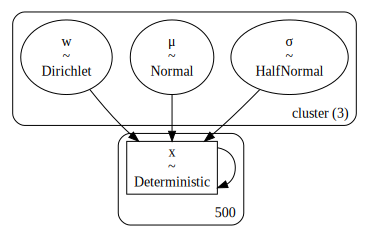

In [11]:
with pm.Model(coords={"cluster": range(k)}) as model:
    μ = pm.Normal(
        "μ",
        mu=0,
        sigma=5,
        transform=pm.distributions.transforms.ordered,
        initval=[-4, 0, 4],
        dims="cluster",
    )
    σ = pm.HalfNormal("σ", sigma=1, dims="cluster")
    weights = pm.Dirichlet("w", np.ones(k), dims="cluster")
    pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=x)

pm.model_to_graphviz(model)

In [12]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/bayes_env/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


We can also plot the trace to check the nature of the MCMC chains, and compare to the ground truth values.

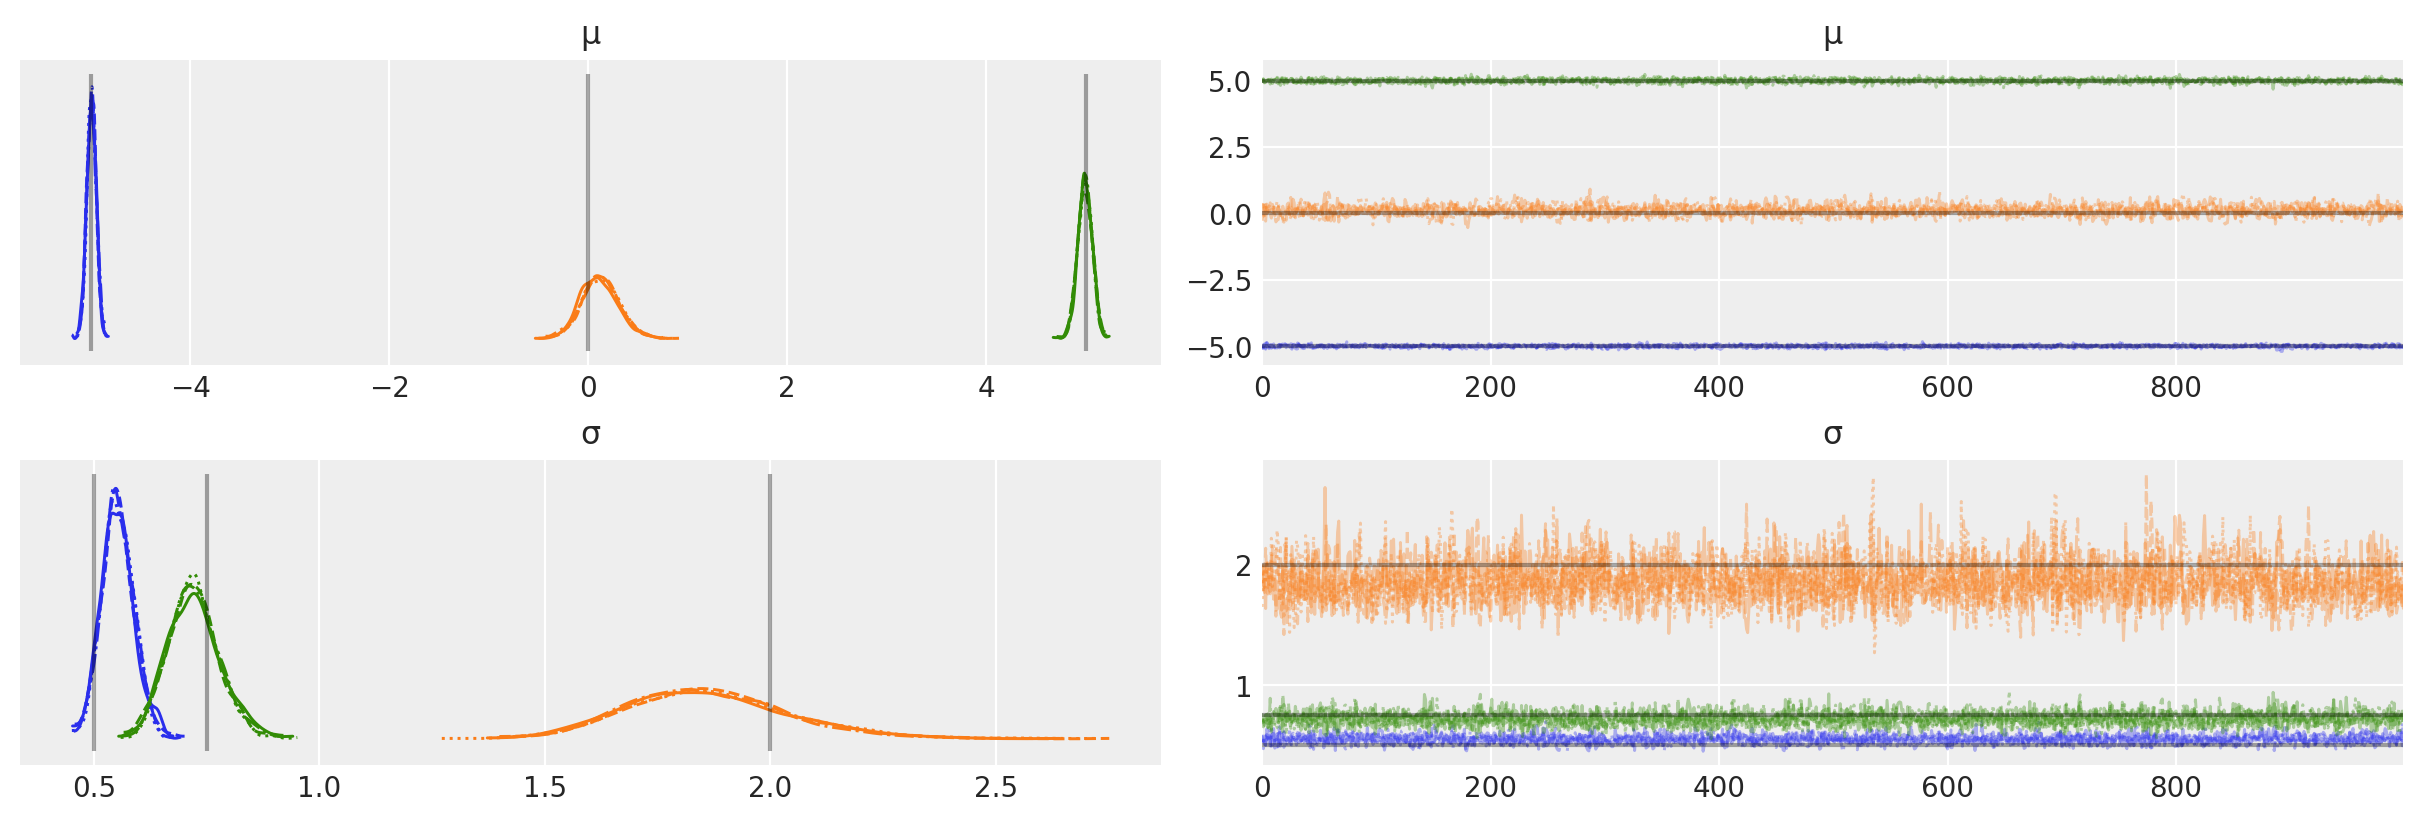

In [16]:
az.plot_trace(idata, var_names=["μ", "σ"], lines=[("μ", {}, [centers]), ("σ", {}, [sds])]);

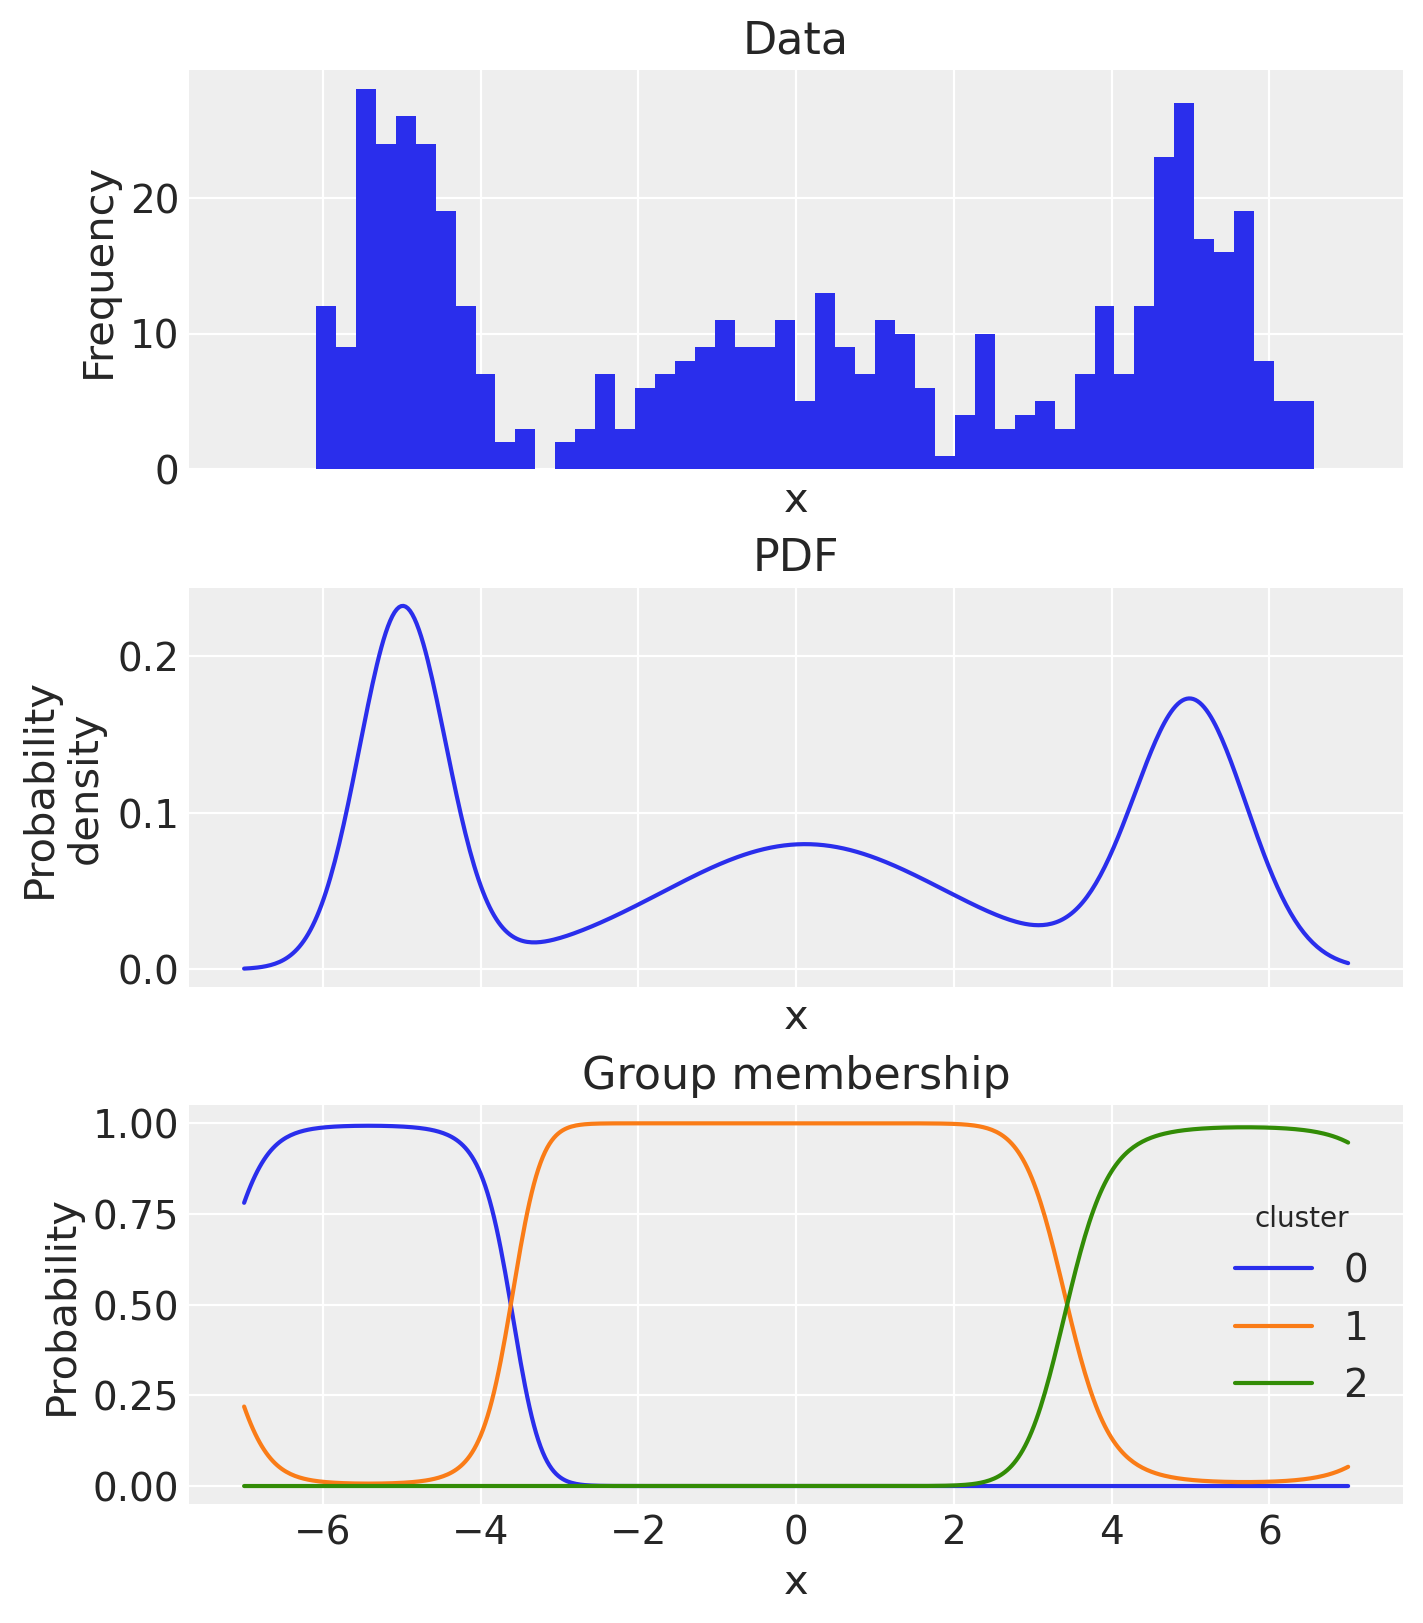

In [14]:
xi = np.linspace(-7, 7, 500)
post = idata.posterior
pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * post["w"]
pdf = pdf_components.sum("cluster")

fig, ax = plt.subplots(3, 1, figsize=(7, 8), sharex=True)
# empirical histogram
ax[0].hist(x, 50)
ax[0].set(title="Data", xlabel="x", ylabel="Frequency")
# pdf
pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
ax[1].set(title="PDF", xlabel="x", ylabel="Probability\ndensity")
# plot group membership probabilities
(pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="cluster", ax=ax[2])
ax[2].set(title="Group membership", xlabel="x", ylabel="Probability");